# Building an Image Similarity System with 🤗 Transformers
- Ref: 
    - https://github.com/huggingface/notebooks/blob/main/examples/image_similarity.ipynb
    - https://camo.githubusercontent.com/c5e4b6bcd6be7fdf6e6c552400ea9ee397c84274256c87538bbfc9622ad2ccd4/68747470733a2f2f692e6962622e636f2f6d5474646837462f656d62656464696e67732e706e67
    - https://github.com/facebookresearch/faiss
    - https://huggingface.co/docs/datasets/faiss_es
    - https://colab.research.google.com/gist/sayakpaul/5b5b5a9deabd3c5d8cb5ef8c7b4bb536/image_similarity_faiss.ipynb

----

### Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)


## Configure device

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


## 1. Building an image similarity system

### Loading a base model to compute embeddings

In [2]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size
print(f"hidden_size :: {hidden_dim}")

/home/hyunjae/anaconda3/envs/dl_drill_pthf/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hidden_size :: 768


### Loading the dataset for candidate images


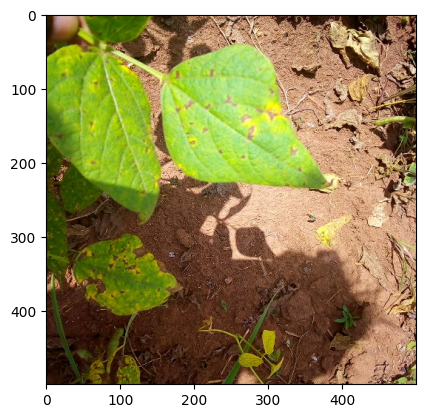

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("beans")
dataset["train"].features
plt.imshow(dataset["train"][0]["image"])

In [4]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [5]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

![Image](https://camo.githubusercontent.com/6088b95b8ccd6c2775253fcf3d3dc4dbd716c901fa9c8507ed4a04eb96a0cabc/68747470733a2f2f692e6962622e636f2f726d32465777662f66657463682d73696d696c61722d70726f636573732e706e67)

In [6]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [7]:
import torch


def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
# device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(t_device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
candidate_subset

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 100
})

In [9]:
candidate_subset_emb

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

In [10]:
from tqdm.auto import tqdm


candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
candidate_ids

['0_1',
 '1_0',
 '2_1',
 '3_0',
 '4_2',
 '5_2',
 '6_2',
 '7_1',
 '8_1',
 '9_2',
 '10_0',
 '11_2',
 '12_0',
 '13_2',
 '14_1',
 '15_2',
 '16_2',
 '17_1',
 '18_0',
 '19_1',
 '20_1',
 '21_1',
 '22_1',
 '23_2',
 '24_0',
 '25_0',
 '26_0',
 '27_1',
 '28_1',
 '29_1',
 '30_0',
 '31_2',
 '32_1',
 '33_2',
 '34_1',
 '35_1',
 '36_0',
 '37_2',
 '38_1',
 '39_1',
 '40_0',
 '41_2',
 '42_2',
 '43_0',
 '44_1',
 '45_0',
 '46_2',
 '47_2',
 '48_0',
 '49_0',
 '50_2',
 '51_2',
 '52_2',
 '53_1',
 '54_0',
 '55_2',
 '56_2',
 '57_0',
 '58_1',
 '59_0',
 '60_0',
 '61_1',
 '62_0',
 '63_0',
 '64_2',
 '65_1',
 '66_1',
 '67_0',
 '68_0',
 '69_2',
 '70_2',
 '71_1',
 '72_2',
 '73_0',
 '74_2',
 '75_2',
 '76_1',
 '77_0',
 '78_1',
 '79_1',
 '80_2',
 '81_0',
 '82_2',
 '83_0',
 '84_2',
 '85_1',
 '86_1',
 '87_1',
 '88_2',
 '89_0',
 '90_2',
 '91_1',
 '92_1',
 '93_2',
 '94_2',
 '95_2',
 '96_0',
 '97_1',
 '98_2',
 '99_1']

In [12]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [ ]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(t_device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [14]:
test_idx = np.random.choice(len(dataset["test"]))
test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 0
Top 5 candidate labels: [0, 0, 0, 0, 0]


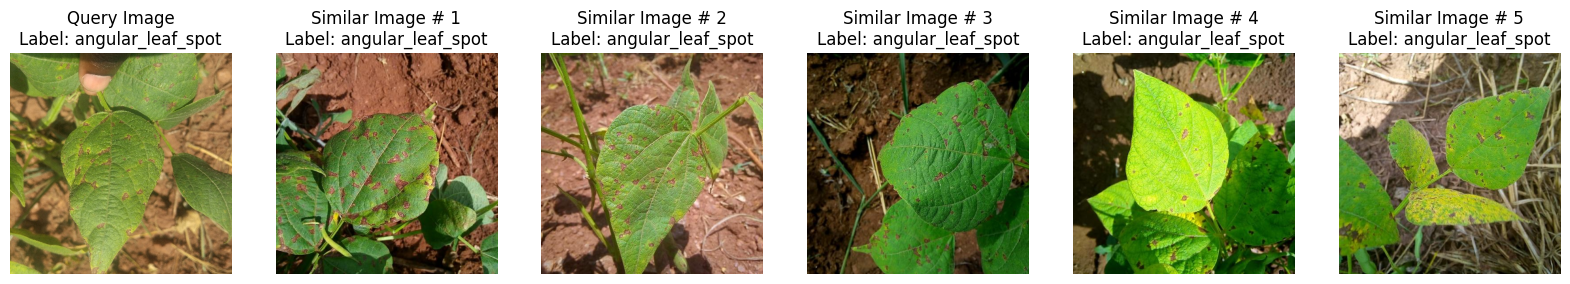

In [15]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

# for id in sim_ids:
#     images.append(candidate_subset_emb[id]["image"])
#     labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

## 2.Random projection and locality-sensitive hashing (LSH)

![Image](https://camo.githubusercontent.com/6873d2137bd932aade22777dabc941a7fb5c7c917f0c192d777ecb4c75276231/68747470733a2f2f64333377756272666b69306c36382e636c6f756466726f6e742e6e65742f356630653765373962333237363931306461343631346633373433326236336137643232366465662f64653265302f696d616765732f6c6f63616c6974792d73656e7369746976652d68617368696e672d31322e6a706567)

In [16]:
hash_size = 8
np.random.seed(seed)


# Define random vectors to project with.
random_vectors = np.random.randn(hash_size, hidden_dim).T


def hash_func(embedding, random_vectors=random_vectors):
    """Randomly projects the embeddings and then computes bit-wise hashes."""
    if not isinstance(embedding, np.ndarray):
        embedding = np.array(embedding)
    if len(embedding.shape) < 2:
        embedding = np.expand_dims(embedding, 0)

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    # print(bools)
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y

In [17]:
print(random_vectors.shape)

t = [False, False, True]
bool2int(t)

(768, 8)


4

In [18]:
from typing import Union


def compute_hash(model: Union[torch.nn.Module, str]):
    """Computes hash on a given dataset."""
    device = model.device

    def pp(example_batch):
        # Prepare the input images for the model.
        image_batch = example_batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in image_batch]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}

        # Compute embeddings and pool them i.e., take the representations from the [CLS]
        # token.
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu().numpy()

        # Compute hashes for the batch of images.
        hashes = [hash_func(embeddings[i]) for i in range(len(embeddings))]
        example_batch["hashes"] = hashes
        return example_batch

    return pp

### The Table class

In [19]:
from typing import List


class Table:
    def __init__(self, hash_size: int):
        self.table = {}
        self.hash_size = hash_size

    def add(self, id: int, hashes: List[int], label: int):
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, hashes: List[int]):
        results = []

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results

### The LSH class

In [20]:
class LSH:
    def __init__(self, hash_size, num_tables):
        self.num_tables = num_tables
        self.tables = []
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size))

    def add(self, id: int, hash: List[int], label: int):
        for table in self.tables:
            table.add(id, hash, label)

    def query(self, hashes: List[int]):
        results = []
        for table in self.tables:
            results.extend(table.query(hashes))
        return results

### The BuildLSHTable class

In [21]:
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()

In [22]:
from PIL import Image
import datasets


class BuildLSHTable:
    def __init__(
        self,
        model: Union[torch.nn.Module, None],
        batch_size: int = 48,
        hash_size: int = hash_size,
        dim: int = hidden_dim,
        num_tables: int = 10,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.num_tables)

        self.batch_size = batch_size
        self.hash_fn = compute_hash(model.to(device))

    def build(self, ds: datasets.DatasetDict):
        dataset_hashed = ds.map(self.hash_fn, batched=True, batch_size=self.batch_size)

        for id in tqdm(range(len(dataset_hashed))):
            hash, label = dataset_hashed[id]["hashes"], dataset_hashed[id]["labels"]
            self.lsh.add(id, hash, label)

    def query(self, image, verbose=True):
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # Compute the hashes of the query image and fetch the results.
        example_batch = dict(image=[image])
        hashes = self.hash_fn(example_batch)["hashes"][0]

        results = self.lsh.query(hashes)
        if verbose:
            print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts = {}
        for r in results:
            if r["id_label"] in counts:
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        return counts

### Building the LSH tables

In [23]:
lsh_builder = BuildLSHTable(model)
lsh_builder.build(dataset["train"].shuffle(seed=seed))

idx = 0
for hash, entry in lsh_builder.lsh.tables[0].table.items():
    if idx == 5:
        break
    if len(entry) < 5:
        print(f"Hash: {hash}, entries: {entry}")
        idx += 1

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

  0%|          | 0/1034 [00:00<?, ?it/s]

Hash: 183, entries: [{'id_label': '12_0'}]
Hash: 119, entries: [{'id_label': '81_0'}, {'id_label': '359_0'}, {'id_label': '724_1'}, {'id_label': '967_0'}]
Hash: 87, entries: [{'id_label': '91_1'}]
Hash: 228, entries: [{'id_label': '94_2'}, {'id_label': '774_2'}, {'id_label': '1002_2'}]
Hash: 81, entries: [{'id_label': '115_2'}]


### Inference

In [24]:
candidate_dataset = dataset["train"].shuffle(seed=seed)


def visualize_lsh(lsh_class: BuildLSHTable, top_k: int = 5):
    idx = np.random.choice(len(dataset["test"]))

    image = dataset["test"][idx]["image"]
    label = dataset["test"][idx]["labels"]
    results = lsh_class.query(image)

    candidates = []
    labels = []
    overlaps = []

    for idx, r in enumerate(sorted(results, key=results.get, reverse=True)):
        if idx == top_k:
            break
        image_id, label = r.split("_")[0], r.split("_")[1]
        candidates.append(candidate_dataset[int(image_id)]["image"])
        labels.append(label)
        overlaps.append(results[r])

    candidates.insert(0, image)
    labels.insert(0, label)

    plot_images(candidates, labels)

Matches: 2340
Matches: 460
Matches: 2340
Matches: 520
Matches: 1140


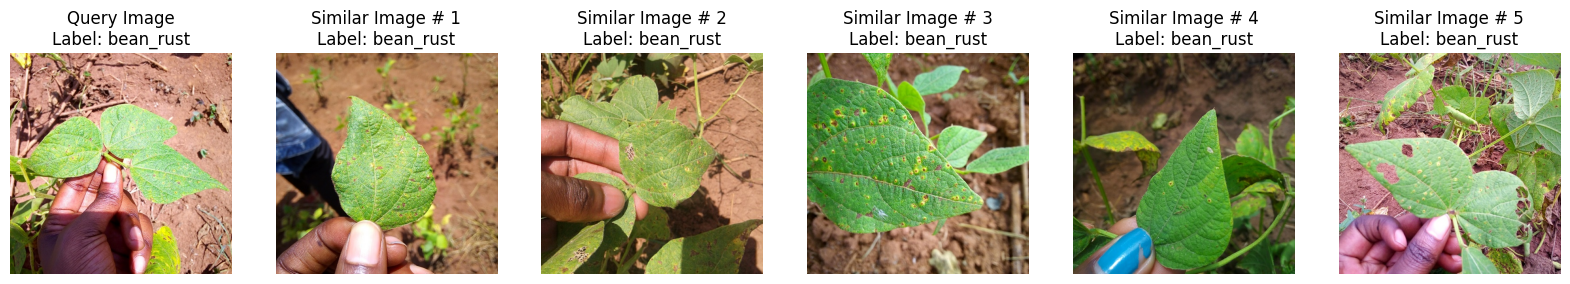

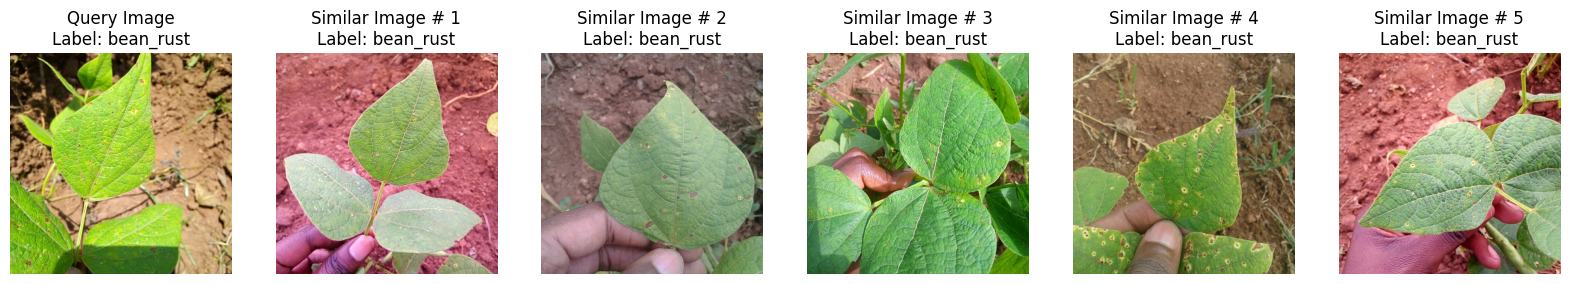

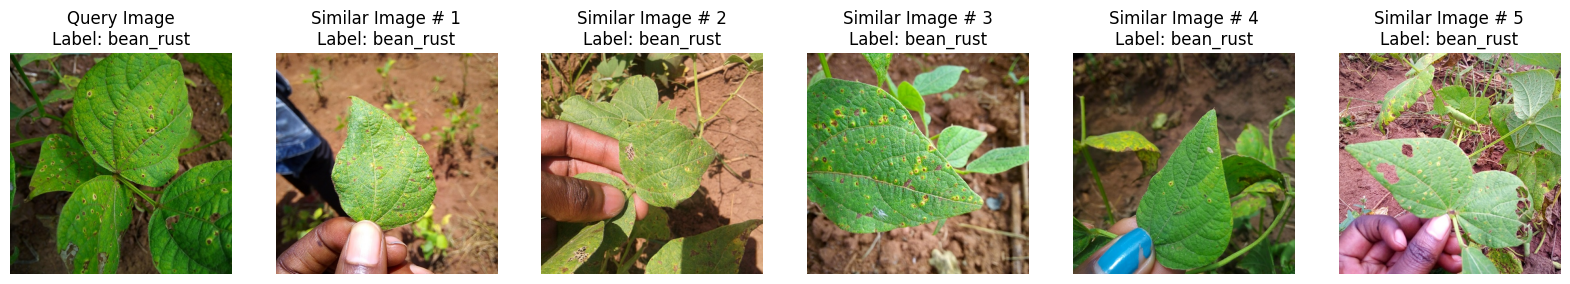

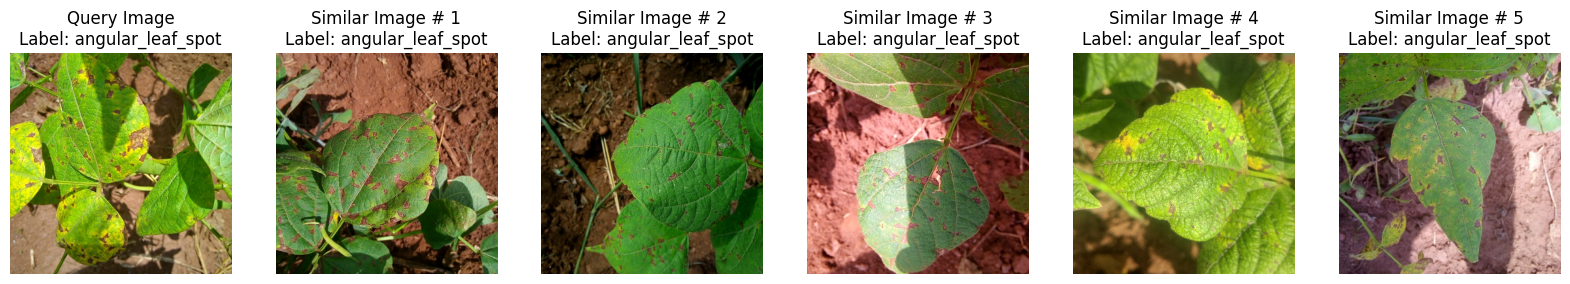

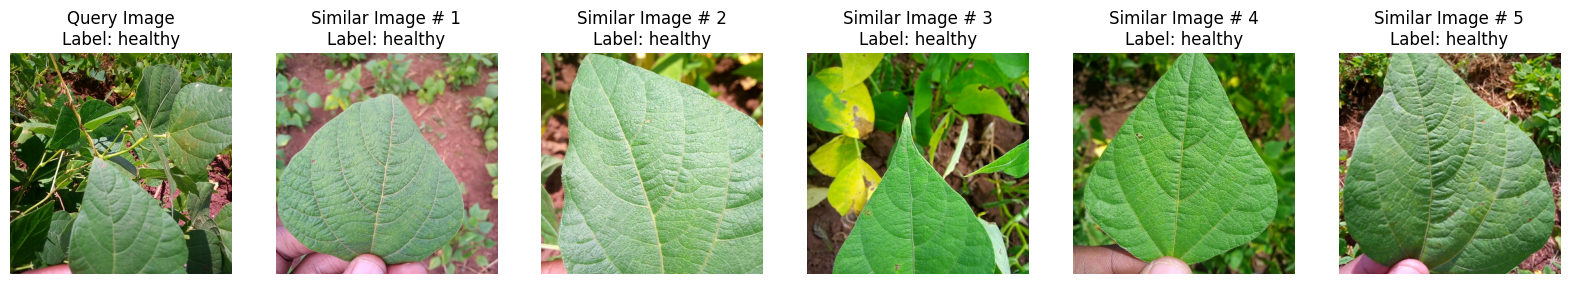

In [25]:
for _ in range(5):
    visualize_lsh(lsh_builder)

In [26]:
print("Done")

Done
